# [任意の地点の標高データを取得・解析する](https://www.tellusxdp.com/ja/howtouse/20200221_000260.html)

In [1]:
import os
import json

fpth_secret = os.path.join(os.environ['HOME'], 'working/jupyter/secret.json')
with open(fpth_secret) as f:
    secret = json.load(f)
TOKEN = secret['tellus']
HEADERS = {
    'Authorization': 'Bearer ' + TOKEN
}

In [2]:
from pathlib import Path

fpth_data = Path.cwd() / 'N03-22_13_220101.geojson'
with open(fpth_data) as f:
    json_data = json.load(f)

setagaya_features = [f for f in json_data['features'] if f['properties']['N03_007'] == '13112']
print(len(setagaya_features))
print(setagaya_features[0])

1
{'type': 'Feature', 'properties': {'N03_001': '東京都', 'N03_002': None, 'N03_003': None, 'N03_004': '世田谷区', 'N03_007': '13112'}, 'geometry': {'type': 'Polygon', 'coordinates': [[[139.58884255464034, 35.68250233321629], [139.58923977979214, 35.682450667164744], [139.58939089467424, 35.68243122472143], [139.5898631133922, 35.682353999937334], [139.5911239431157, 35.682190945655805], [139.59158033736287, 35.682108171155335], [139.59166666688338, 35.682105892273285], [139.59166978033625, 35.682105802341084], [139.59169866386242, 35.68210483826783], [139.59190144029935, 35.68209955924743], [139.59207089505594, 35.68209483780669], [139.5922475623753, 35.68205899982314], [139.59234033733685, 35.68203066668207], [139.59238477283918, 35.68201733333342], [139.59275391666006, 35.68190483803801], [139.59301669316608, 35.68180733264245], [139.5933039168425, 35.681737892390004], [139.59334391688844, 35.68176150498965], [139.59366836620234, 35.681954000377004], [139.59378447497375, 35.68200066709727]

(768, 512, 3)


/home/ubuntu/working/venv/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


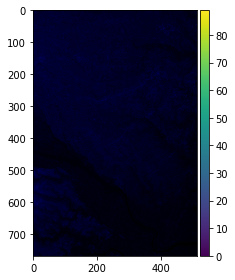

In [3]:
import requests

import numpy as np
from io import BytesIO
from skimage import io

def fetch_asterdem3_dsm_image(tile):
    url = 'https://gisapi.tellusxdp.com'
    url += '/astergdem3/dsm/{z}/{x}/{y}.png'
    url = url.format(**tile)
    
    r = requests.get(url, headers=HEADERS)
    return io.imread(BytesIO(r.content))

def fetch_asterdem3_dsm_images(tile, size):
    col_img = []
    for x in range(size['x']):
        img = []
        for y in range(size['y']):
            tile_temp = tile.copy()
            tile_temp['x'] += x
            tile_temp['y'] += y
            img.append(fetch_asterdem3_dsm_image(tile_temp))
        col_img.append(np.vstack(img))
    return np.hstack(col_img)
    
tile = {
    'x': 3636,
    'y': 1612,
    'z': 12
}
size = {
    'x': 2,
    'y': 3
}
img_setagaya = fetch_asterdem3_dsm_images(tile, size)
print(img_setagaya.shape)
io.imshow(img_setagaya)

In [4]:
import math

from skimage.draw import polygon

def num2deg(xtile, ytile, zoom):
    # https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Python
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lon_deg, lat_deg)
    
def calc_tile_bbox(tile, size):
    """
    タイル座標からバウンディングボックスを取得
    https://tools.ietf.org/html/rfc7946#section-5
    """
    right_top = num2deg(tile['x'] + size['x'], tile['y'], tile['z'])
    left_bottom = num2deg(tile['x'], tile['y'] + size['y'], tile['z'])
    return (left_bottom[0], left_bottom[1], right_top[0], right_top[1])
    
def world2pixel(bbox, size, lon, lat):
    """
    世界座標 (緯度経度) を画像座標 (ピクセル) に変換
    """
    dist = (
        (bbox[2] - bbox[0]) / size[0],
        (bbox[3] - bbox[1]) / size[1]
    )
    pixel = (
        int((lon - bbox[0]) / dist[0]),
        int((bbox[3] - lat) / dist[1])
    )
    return pixel

def get_polygon_image(points, bbox, dct_img_size):
    pixels = []
    img_size = (dct_img_size['width'], dct_img_size['height'])
    for p in points:
        pixels.append(world2pixel(bbox, img_size, p[0], p[1]))
    pixels = np.array(pixels)
    poly = np.ones((img_size[1], img_size[0]), dtype=np.uint8)
    rr, cc = polygon(pixels[:, 1], pixels[:, 0], poly.shape)
    poly[rr, cc] = 0
    return poly

/home/ubuntu/working/venv/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


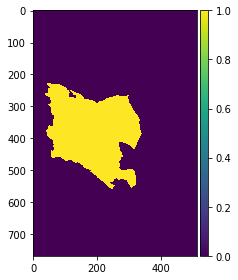

In [5]:
def calc_mask_image(features, bbox, px_size):
    ims = []
    for feature in features:
        points = feature['geometry']['coordinates'][0]
        ims.append(get_polygon_image(points, bbox, px_size))
    mask = np.where((ims[0] > 0), 0, 1)
    for i in range(1, len(ims)):
        mask = mask + np.where((ims[i] > 0), 0, 1)
    return np.where((mask > 0), 1, 0).astype(np.uint8)

bbox = calc_tile_bbox(tile, size)
px_size = {'height': img_setagaya.shape[0], 'width': img_setagaya.shape[1]}
mask = calc_mask_image(setagaya_features, bbox, px_size)
io.imshow(mask)

In [6]:
mask = np.repeat(mask[:, :, None], 3, axis=2) # (h, w) -> (h, w, c)
img_setagaya_mask = img_setagaya * mask
print(img_setagaya_mask.shape)

(768, 512, 3)


In [7]:
def calc_height_img(img_rgb, u=100):
    r_ch, g_ch, b_ch = np.squeeze(np.split(img_rgb, 3, axis=-1))
    heights = np.zeros_like(r_ch, dtype=np.int64)
    
    heights = r_ch * 256 * 256 + g_ch * 256 + b_ch
    heights = np.where(heights > 2 ** 23, (heights - 2 ** 24) * u, heights)
    heights = np.where(heights < 2 ** 23, heights * u, heights)
    
    heights_err = np.where(heights == 2 ** 23)
    heights = np.where(heights == 2 ** 23, 0, heights)
    
    return heights[heights > 0], heights_err
    
z, err = calc_height_img(img_setagaya_mask, u=1)

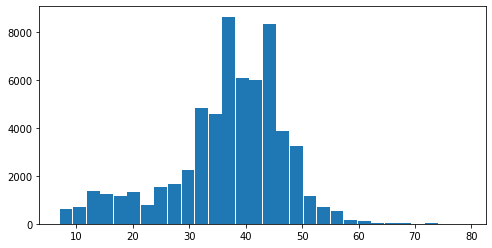

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
plt.hist(z, bins=30, rwidth=0.95)
plt.show()

In [9]:
print('std: ', np.std(z))
print('mean:', np.mean(z))
print('max: ', np.max(z))
print('min: ', np.min(z))

std:  10.113964118699608
mean: 36.79228739531606
max:  79
min:  7
